# Preprocessing of Datasets

After installation a dataset needs some steps of preprocessing before being fed to down-stream pipelines. This tutorial shows how to do set up a pipeline of preprocessing for a built dataset. In general the pipeline consists of transformations at 3 consecutive levels:

1. File-level preprocessing: data selection, label modification, signal resampling & truncation etc.
2. Data-level preprocessing: feature extraction, windowed view, data augmentation etc.
3. Model-level preprocessing: modification to meet the specification of a machine learning model.

At the end of pipeline, the dataset will be transformed to some appropriate form for being used with some ML model.

We use the dataset CWRU as example in this tutorial, but the same principle can be adapted to other datasets.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import librosa
import librosa.display

import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

from IPython.display import Audio

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = "/home/han/Database/tensorflow_datasets"  # default location of tfds database

In [2]:
import dpmhm

from dpmhm.datasets import transformer, preprocessing, feature, utils

## Load a built dataset

Suppose the dataset CWRU has been correctly installed, first we need to load the built dataset into memory. Note that the original dataset doesn't specify any split, and all data are contained in the field `train` of the built dataset.

In [3]:
dataset_name = 'CWRU'

ds_all, ds_info = tfds.load(
    dataset_name, 
    # data_dir='/home/han/Database/tensorflow_datasets/',
    # split=['train[:75%]', 'train[75%:]'],    
    with_info=True,
    download=False,
    # batch_size=-1,  # load the whole dataset into a single batch
#     download_and_prepare_kwargs
)

print(ds_all.keys())  # show the split of the raw dataset

ds0 = ds_all['train']

dict_keys(['train'])


2023-01-04 15:36:48.480768: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-04 15:36:48.480793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Pluto): /proc/driver/nvidia/version does not exist
2023-01-04 15:36:48.481185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The method `.element_spec()` shows the specification of data elements. Recall that a built dataset of `dpmhm` always contains the fields `{'label', 'signal', 'sampling_rate', 'metadata'}`.

In [4]:
ds0.element_spec

{'label': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'metadata': {'FaultComponent': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultLocation': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultSize': TensorSpec(shape=(), dtype=tf.float32, name=None),
  'FileName': TensorSpec(shape=(), dtype=tf.string, name=None),
  'LoadForce': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'NominalRPM': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'RPM': TensorSpec(shape=(), dtype=tf.uint32, name=None)},
 'sampling_rate': TensorSpec(shape=(), dtype=tf.uint32, name=None),
 'signal': {'BA': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'DE': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'FE': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}}

We note for CWRU that
- `metadata` has a subfiled `FaultLocation`, but this is a redundant copy of the field `label`.
- The normal data can be equivalently identified by any of the following clauses: `label==0`, `FaultComponent==None`, `FaultSize==0`.


Let's plot and play a sample from the dataset:

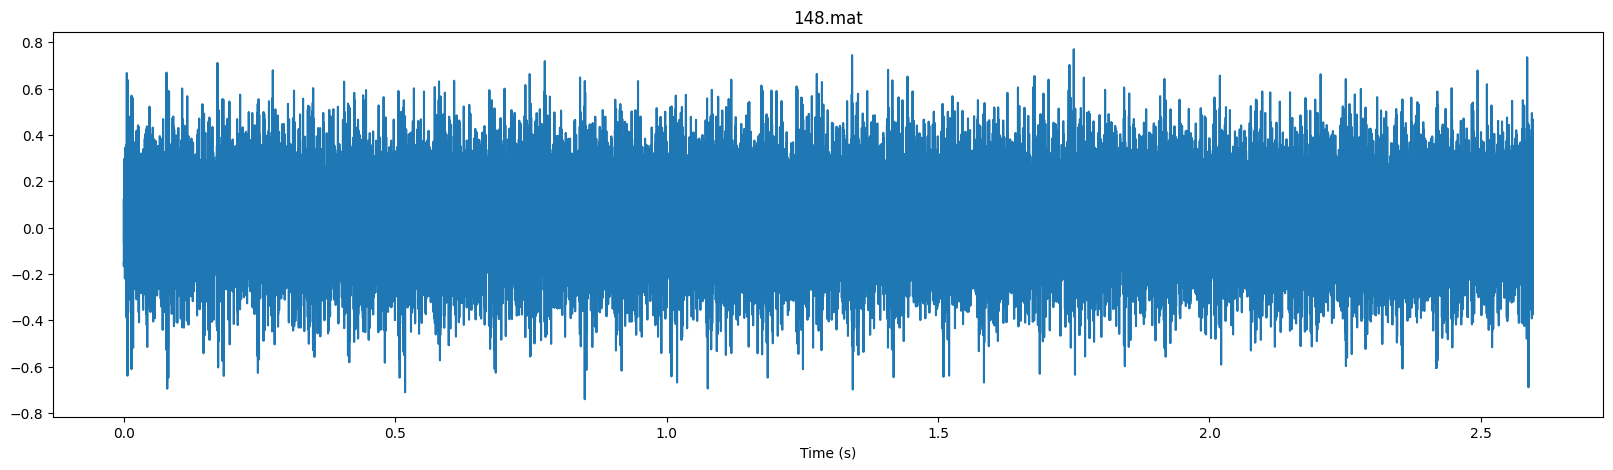

In [5]:
eles = list(ds0.take(10).as_numpy_iterator())

fn = eles[0]['metadata']['FileName'].decode()
sr = eles[0]['sampling_rate']
x = eles[0]['signal']['FE']

plt.figure(figsize=(20,5))
plt.plot(np.arange(len(x))/sr, x)
plt.xlabel('Time (s)')
plt.title(fn)

Audio(x, rate=sr)

## File-level preprocessing

These are preprocessings applied at the level of original records (or data files). 

#### Filter on the channels
CWRU contains 3 channels ['DE', 'FE', 'BA'], however some channels may be absent in certain files (e.g. the file '148.mat' contains only channels 'DE' and 'FE', not 'BA'). A first preprocessing is to select only the files in which some desired channels are simultaneously present, so that the number of channels is fixed. 

#### Ramification of labels
The original label takes value in ['None', 'DriveEnd', 'FanEnd'] (or the numeric value [0,1,2]), meaning that
- there is no fault
- the fault locates at the drive-end
- the fault locates at the fan-end

We want to incorporate more information and make new labels at a finer level, for example by taking into account the subfield `FaultComponent` and `FaultSize` of the field `metadata`:
- `FaultComponent`: taking value in {'InnerRace', 'Ball', 'OuterRace3', 'OuterRace6', 'OuterRace12', 'None'}
- `FaultSize`: taking value in {0.007, 0.014, 0.021, 0.028, 0}

Together with the original label, the new label becomes a triplet `(label, FaultComponent, FaultSize)`. For example, the triplet `(1, 'InnerRace', 0.007)` means the fault is located at drive-end, on the inner-race component, and of size 0.007.

#### Resampling & sliding window view
The record in CWRU has variant duration (~ 10 or 2.5 seconds) and sampling rate (at 12000 or 48000 Hz), which may complicate the subsequent analysis. So we resample all signals at the fixed rate of 12000 Hz and trim them into windows of 1 second with hop size 0.5 second.

#### Selection of domain 
We define *domain* as the operating load force of a record. Note that in CWRU the field `LoadForce` (taking value in [0,1,2,3]) is one-to-one mapped to the nominal RPM `NominalRPM` (taking value in [797, 1772, 1750, 1730]). We want to test if an algorithm of detection trained on some domains can work on the others (called *domain-shift*).



### `DatasetCompactor` class

The class `dpmhm.datasets.transformer.DatasetCompactor` provides functionalities for the file-level preprocessing. Let's define the parameters of preprocessing and construct a compactor object. 

In [6]:
# Filter on the channels
channels = ['DE', 'FE', 'BA']  # containing all channels
# channels = ['DE']  # containing only the channel 'DE'

# Label ramification
keys = ['FaultComponent', 'FaultSize']  # finest label
# keys = []  # original label

# Selection of domain
# filters = {'LoadForce': [0,1,2]}  # source domain
filters = {}

# Resampling rate
resampling_rate = 12000
# resampling_rate = None  # no resampling

# Size of the sliding window (after resampling)
window_size = resampling_rate  # 1 second

# Number of samples between sucessive window
hop_size = window_size//2

from dpmhm.datasets import transformer

compactor = transformer.DatasetCompactor(ds0, channels=channels, keys=keys, filters=filters,
                                         resampling_rate=resampling_rate, 
                                         window_size=window_size, hop_size=hop_size)

The new construction has the property `dataset` which is the transformed dataset. Let's compare the new signature of 'signal' to the original one:

In [7]:
ds1 = compactor.dataset

print('Original:', ds0.element_spec['signal'])
print('Compacted:', ds1.element_spec['signal'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Original: {'BA': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'DE': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'FE': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}
Compacted: TensorSpec(shape=(3, None), dtype=tf.float32, name=None)


And take some elements from the new dataset:

In [8]:
eles1 = list(ds1.take(10).as_numpy_iterator())
eles0 = list(ds0.take(10).as_numpy_iterator())

As expected, the new field 'signal' is now a 2D-array of fixed shape (3 channels and 12000 points):

In [9]:
for n, X in enumerate(eles1):
    print(n, f"label={X['label'].decode()}, shape={X['signal'].shape}")

0 label=d39d8931, shape=(3, 12000)
1 label=d39d8931, shape=(3, 12000)
2 label=d39d8931, shape=(3, 12000)
3 label=d39d8931, shape=(3, 12000)
4 label=d39d8931, shape=(3, 12000)
5 label=d39d8931, shape=(3, 12000)
6 label=d39d8931, shape=(3, 12000)
7 label=d39d8931, shape=(3, 12000)
8 label=d39d8931, shape=(3, 12000)
9 label=d39d8931, shape=(3, 12000)


The new label is an apparently random string. The property `compactor.full_label_dict` allows to find out the meaning of new labels. It can be seen that the label `d39d8931` corresponds to the category `FaultLocation=2` (2 for 'FanEnd'), `FaultComponent='InnerRace'` and `FaultSize=0.014`. This property actually contains all possible labels that can be found in the dataset.

In [10]:
compactor.full_label_dict

{'d39d8931': ['2', 'InnerRace', '0.014'],
 'a126b311': ['1', 'Ball', '0.007'],
 '10d51e0c': ['1', 'OuterRace6', '0.014'],
 'ada901bd': ['2', 'Ball', '0.014'],
 '19b7c8c9': ['1', 'OuterRace12', '0.007'],
 'ecb9fb89': ['2', 'InnerRace', '0.007'],
 '6607c34e': ['2', 'OuterRace3', '0.014'],
 'aa676c6c': ['1', 'Ball', '0.021'],
 '2c9f2adc': ['2', 'OuterRace3', '0.007'],
 '445d82dc': ['1', 'OuterRace12', '0.021'],
 'faff6146': ['1', 'InnerRace', '0.021'],
 'f9b9bb12': ['2', 'OuterRace3', '0.021'],
 '53138cc8': ['1', 'Ball', '0.014'],
 '1f9da202': ['1', 'OuterRace3', '0.007'],
 '4b9452e7': ['2', 'InnerRace', '0.021'],
 '6a669739': ['1', 'OuterRace3', '0.021'],
 '894b6e49': ['2', 'Ball', '0.021'],
 '04941fda': ['2', 'OuterRace6', '0.007'],
 '7e297d6f': ['2', 'Ball', '0.007'],
 '921c54c7': ['2', 'OuterRace12', '0.007'],
 'ca79b89c': ['1', 'InnerRace', '0.014'],
 '9b317898': ['1', 'OuterRace6', '0.007'],
 '42be485a': ['1', 'InnerRace', '0.007'],
 '758085eb': ['1', 'OuterRace6', '0.021'],
 '7b612

We notice also that the several first elements in the new dataset all have the same `metadata`: this is of cause due to the sliding window view on the same data file '274.mat'.

In [11]:
for X in eles1:
    print(X['metadata'])

{'FaultComponent': b'InnerRace', 'FaultLocation': b'FanEnd', 'FaultSize': 0.014, 'FileName': b'274.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'FaultComponent': b'InnerRace', 'FaultLocation': b'FanEnd', 'FaultSize': 0.014, 'FileName': b'274.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'FaultComponent': b'InnerRace', 'FaultLocation': b'FanEnd', 'FaultSize': 0.014, 'FileName': b'274.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'FaultComponent': b'InnerRace', 'FaultLocation': b'FanEnd', 'FaultSize': 0.014, 'FileName': b'274.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'FaultComponent': b'InnerRace', 'FaultLocation': b'FanEnd', 'FaultSize': 0.014, 'FileName': b'274.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'FaultComponent': b'InnerRace', 'FaultLocation': b'FanEnd', 'FaultSize': 0.014, 'FileName': b'274.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'FaultComponent': b'InnerRace', 'FaultLocation': b'FanEnd', 'FaultSize': 0.

As expected the first two records of the new dataset has a common part (plot in red) of length `hop_size`:

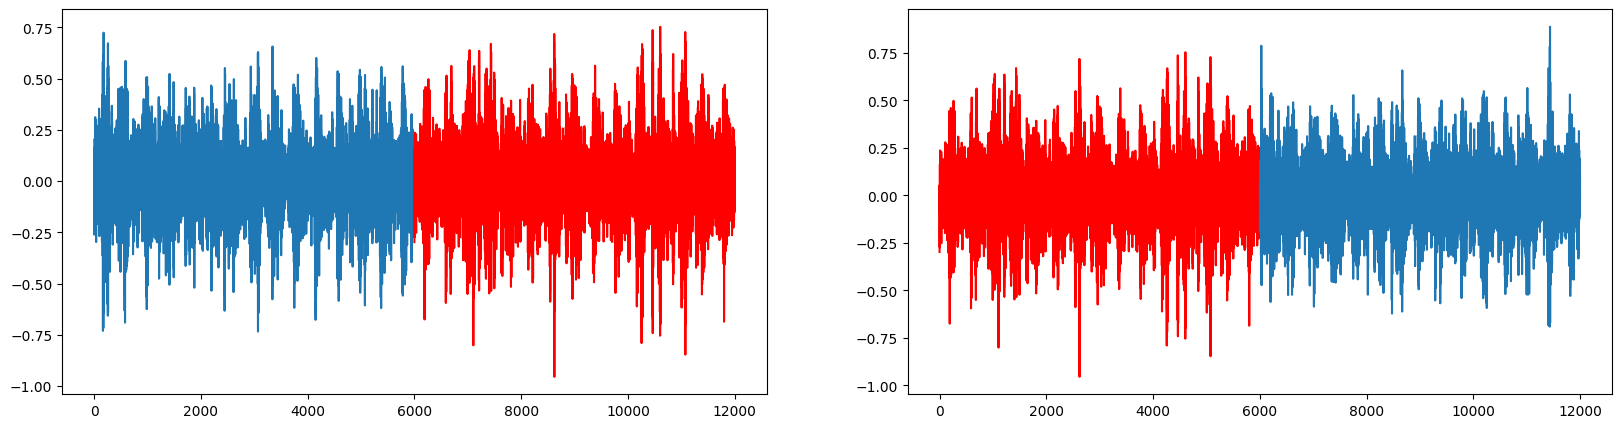

In [12]:
x0, x1 = eles1[0]['signal'][0], eles1[1]['signal'][0]

fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.arange(len(x0)//2), x0[:len(x0)//2])
axes[0].plot(np.arange(len(x0)//2, len(x0)), x0[len(x0)//2:], 'r')

axes[1].plot(np.arange(len(x1)//2), x1[:len(x1)//2], 'r')
axes[1].plot(np.arange(len(x1)//2, len(x1)), x1[len(x1)//2:])

# axes[1].plot(x1); axes[1].plot(x1[:len(x1)//2], 'b')

assert np.allclose(x0[hop_size:], x1[:hop_size])

## Data-level preprocessing

Data-level preprocessing aims at transform the original waveform data to more advanced representation (e.g. spectrogram), and are applied after file-level preprocessings. Hereafter is some examples of data-level preprocessing.

#### Waveform augmentation
Currently not supported by `dpmhm`, see:

https://github.com/facebookresearch/WavAugment

#### Feature extraction
The following feature trasnformations are implemented in `dpmhm`:
- Time-Frequency representation: spectrogram, MFCC etc.
- Cyclostationary representation
- Time-Scale representation: scalogram, EMD etc.

The output is a 2D representation of the original waveform. Implemented by `FeatureExtractor` class.

#### Sliding window view
Take a sliding window view on the 2D feature representation. The window has a fixed shape and moves at regular step in the 2D representation. Implemented by `WindowSlider` class.

#### Spectrogram augmentation
Perform random agumentations on a 2D feature representation. As the sliding window view, the output is also a 2D patch of fixed dimension. Implemented by `SpecAugment` class.


In the next we show how to apply data-level preprocessing. We start by some file-level preprocessing, including channel selection, label ramification and resampling:

In [13]:
# File-level parameters
channels = ['DE', 'FE']

keys = ['FaultComponent', 'FaultSize']  # finest label

compactor = transformer.DatasetCompactor(ds0, channels=channels, keys=keys, resampling_rate=12000)

### `FeatureExtractor` class

This class allows to transform the original 1d waveform to some 2d representation, e.g. spec, mfcc.

In [14]:
from dpmhm.datasets import feature

_func = lambda x, sr: feature.spectrogram(x, sr, time_window=0.025, hop_step=0.0125, 
                                          to_db=True, normalize=False)[0]

# _func = lambda x, sr: feature.melspectrogram(x, sr, time_window=0.025, hop_step=0.0125, 
#                                              n_mels=128, normalize=False)

extractor = transformer.FeatureExtractor(compactor.dataset, _func)

The feature-transformed dataset is again contained in the property `.dataset`. Let's take some elements from it.

In [19]:
ds2 = extractor.dataset

eles2 = list(ds2.take(10).as_numpy_iterator())

The feature transformed dataset shares the same `label` and `metadata` of the compacted dataset:

In [17]:
ds1 = compactor.dataset
eles1 = list(ds1.take(10).as_numpy_iterator())

assert eles2[0]['metadata'] == eles1[0]['metadata']

assert eles2[0]['label'] == eles1[0]['label']

But the field `signal` is now replaced by `feature` which is the spectrogram of the original signal. It is a fixed-size 3D array with axes `(channel, frequency, time)`.

In [18]:
eles2[2]['feature'].shape

(2, 257, 811)

Let's show a sample from the feature transformed dataset.

Text(0, 0.5, 'Frequency bin')

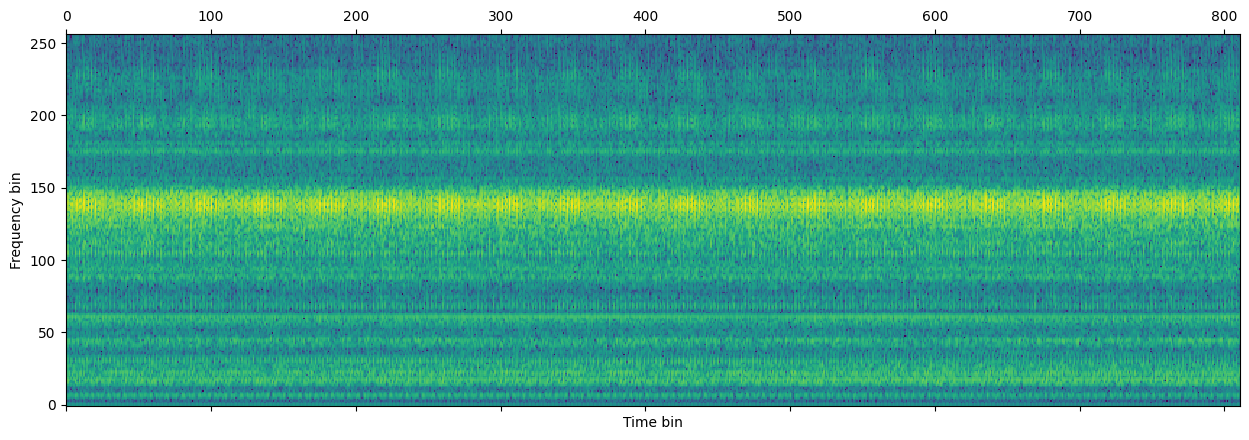

In [39]:
X = eles2[9]
plt.matshow(X['feature'][0], origin='lower')
plt.xlabel('Time bin')
plt.ylabel('Frequency bin')

### `WindowSlider` class

This class allows to get a sliding window view of a 2D representation. It takes as input the dataset of some feature extractor and apply a rectangle window with regular step. The output is the data on the window hence has  fixed dimension.

In [6]:
window = transformer.WindowSlider(extractor.dataset, window_size=(64,64), hop_size=(32,32))

ds3 = window.dataset

eles3 = list(ds3.take(10).as_numpy_iterator())

Text(0, 0.5, 'Frequency bin')

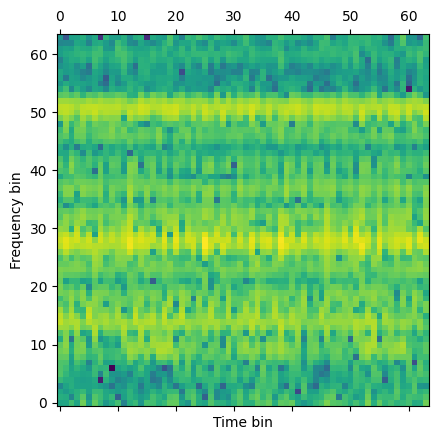

In [41]:
X = eles3[9]
plt.matshow(X['feature'][0], origin='lower')
plt.xlabel('Time bin')
plt.ylabel('Frequency bin')

### `SpecAugment` class

This class performs random augmentations on a feature dataset:

1. crop a random rectangle patch of the spectrogram
2. randomly flip the time axis
3. randomly blur the spectrogram
4. randomly fade along the time axis
     
These augmentations are applied in order and independently with probability (for step 2,3,4, step 1 is always applied). Note that the random patch in step 1 actually consists in resizing a random rectangle area satisfying some prescribed area & aspect constraints to a desired shape, therefore is different from the sliding window view of `WindowSlider` class which is just a simple view (without resizing).

In [51]:
specaug = transformer.SpecAugment(extractor.dataset, output_shape=(64, 64))

ds4 = specaug.dataset

eles4 = list(ds4.take(20).as_numpy_iterator())

Text(0, 0.5, 'Frequency bin')

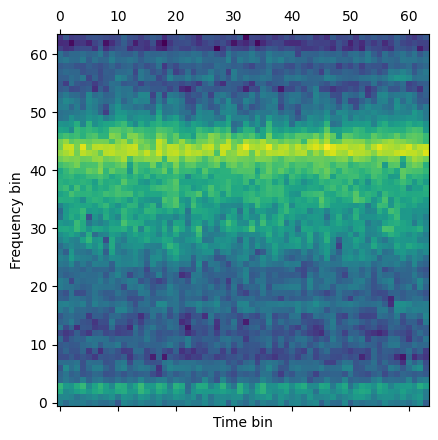

In [52]:
X = eles4[1]
plt.matshow(X['feature'][0], origin='lower')
plt.xlabel('Time bin')
plt.ylabel('Frequency bin')

Let's single out the random crop in step 1. The following code shows its actions under the hood. The output is the resize of a random rectangle area (in red) to a desired shape.

(107, 67) (663, 38)


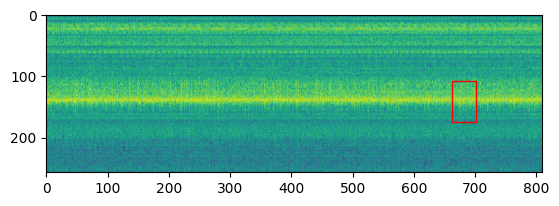

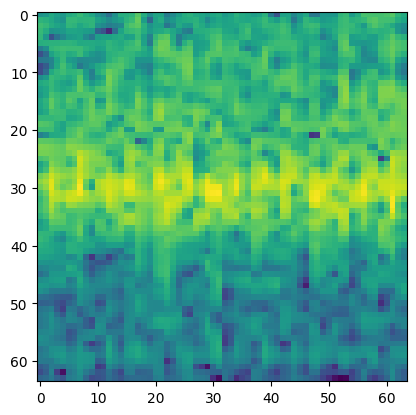

In [55]:
X = eles2[1]['feature']

import matplotlib.patches as patches

Y, hh, ww = dpmhm.datasets.augment.random_crop(X, (64,64), area_ratio=(0.01,1.), aspect_ratio=(1/2,2), channel_axis=0)
print(hh, ww)

plt.figure(); ax=plt.gca()
ax.imshow(X[0])
rect = patches.Rectangle((ww[0], hh[0]), ww[1], hh[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.figure()
plt.imshow(Y[0])

## Model-level preprocessing

After the data-level preprocessing, the original data are transformed into appropriate format and dimension and can be used for training ML models. The model-level preprocessing is the ultimate adaptation of data to the specification of the ML model, and may include 
- label conversion: from string to integer
- channel conversion: from channel first to channel last
- create paired view
- load data by mini-batches & normalization
- ...

In this last section, we show how to apply model-level preprocessing and train an auto-encoder for spectrogram denoising.

### Auto-Encoder for spectrogram denoising

We will reuse the sliding window view dataset created in the data-level preprocessing step, which is contained in the object `window`. First let's randomly split the whole dataset into training/validation/test using the method `utils.split_dataset()`. Note that this step may be time-consuming since it has to iterate over the entire dataset.

In [119]:
from dpmhm.models import autoencoder

In [181]:
splits = {'train':0.7, 'val':0.2, 'test':0.1}

%time dw_split = utils.split_dataset(window.dataset, splits)

for k, ds in dw_split.items():
    print(k, utils.get_dataset_size(ds))  # len(ds) or ds.cardinality() might not work here

CPU times: user 31.7 s, sys: 1.04 s, total: 32.7 s
Wall time: 20.4 s


2023-01-04 14:08:10.368300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13497 of 26005
2023-01-04 14:08:19.911314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


train 18203


2023-01-04 14:08:33.032617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13910 of 26005
2023-01-04 14:08:41.968086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


val 5201


2023-01-04 14:08:52.983970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13665 of 26005
2023-01-04 14:09:02.419250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


test 2601


Note that at this point the dataset is channel-first and its label is in string format.

In [188]:
eles = list(dw_split['train'].take(10).as_numpy_iterator())

print("dimension:", eles[0]['feature'].shape)
print("label:", eles[0]['label'])

2023-01-04 14:17:06.776299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13497 of 26005


dimension: (2, 64, 64)
label: b'aa676c6c'


2023-01-04 14:17:16.274812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


#### Keras preprocessing model

Noew we use Keras preprocessing layers to convert the label from string to integer and make the dataset channel-last. This is done via the method `keras_model_supervised()`.

**Gotcha**:
The processed labels typically reserves the first numbers to out-of-distribution class (e.g. 0 if only one ood is used). The number of classes passed to the Keras model must be accordingly modified (e.g. increasing by 1).

In [189]:
labels = list(compactor.full_label_dict.keys())  # need the whole list of labels

preprocessing_model = preprocessing.keras_model_supervised(dw_split['train'], labels, normalize=False)

Now apply the preprocessing model on the split data.

In [190]:
ds_split = {}

for k,v in dw_split.items():
    ds_split[k] = v.map(preprocessing_model, num_parallel_calls=tf.data.AUTOTUNE)#.map(lambda x,y: (x, y-1))

# set([y.numpy() for x,y in ds_split['val']])

After preprocessing an element from the dataset follows the channel-last convention and has integer labels. Moreover, the data structure now is changed to tuple.

In [191]:
ds_split['train'].element_spec

(TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None),
 TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))

In [185]:
eles = list(ds_split['train'].take(10).as_numpy_iterator())

print("dimension:", eles[0][0].shape)
print("label:", eles[0][1])

2023-01-04 14:10:02.808634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13910 of 26005


dimension: (64, 64, 2)
label: 11


2023-01-04 14:10:12.005990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


#### Batch and shuffle
The last step before training a ML is to make batched and shuffled dataset. This is easily done with the methods `.shuffle()` and `.batch()`.

In [88]:
batch_size = 16

ds_size = 5000  # use a large number
ds_train = ds_split['train'].shuffle(ds_size, reshuffle_each_iteration=True).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_split['val'].shuffle(ds_size, reshuffle_each_iteration=True).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_split['test'].shuffle(ds_size, reshuffle_each_iteration=True).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

Now we can build an convolution AE stacks (CAES) model:

In [91]:
input_shape = eles[0][0].shape
# n_classes = len(labels)+1  # must add one for the outlier class, Keras uses zero-based class labels.
# print(n_classes, input_shape)

config = autoencoder.Config(input_shape=input_shape)  # configuration for AE

model = autoencoder.CAES(config)  # build an AE model

# model.summary()
model.encoder.summary()
model.decoder.summary()

In [122]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    # metrics=['accuracy'],
)

#### Training of AE
AE is a unsupervised model so we drop the label information during the training:

In [160]:
history = model.fit(
    ds_train.map(lambda x,l:(x,x)),
    validation_data=ds_val.map(lambda x,l:(x,x)),
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/10
1138/1138 [==============================] - 59s 52ms/step - loss: 32.2395 - val_loss: 32.2713
Epoch 2/10
1138/1138 [==============================] - 62s 55ms/step - loss: 32.2797 - val_loss: 32.4888
Epoch 3/10
1138/1138 [==============================] - 59s 52ms/step - loss: 31.0930 - val_loss: 30.6160
Epoch 4/10
1138/1138 [==============================] - 56s 49ms/step - loss: 30.2969 - val_loss: 30.3418
Epoch 5/10
1138/1138 [==============================] - 55s 48ms/step - loss: 30.1381 - val_loss: 29.9867
Epoch 6/10
1138/1138 [==============================] - 56s 49ms/step - loss: 30.2933 - val_loss: 29.9478
Epoch 7/10
1138/1138 [==============================] - 55s 48ms/step - loss: 29.8833 - val_loss: 29.8938
Epoch 8/10
1138/1138 [==============================] - 55s 48ms/step - loss: 29.6875 - val_loss: 29.7944
Epoch 9/10
1138/1138 [==============================] - 56s 49ms/step - loss: 29.5399 - val_loss: 29.7637
Epoch 10/10
1138/1138 [=======================

We test the trained AE on test data and visualize the effect of denoising.

In [146]:
x, _ = list(ds_test.take(10))[1]  # take an element from the test set

In [161]:
y = model(x)  # reconstruction

In [173]:
ch = 0
n = 1
a = x[n][:,:,ch]
b = y[n][:,:,ch]

Text(0.5, 1.0, 'Spectrogram patch: original')

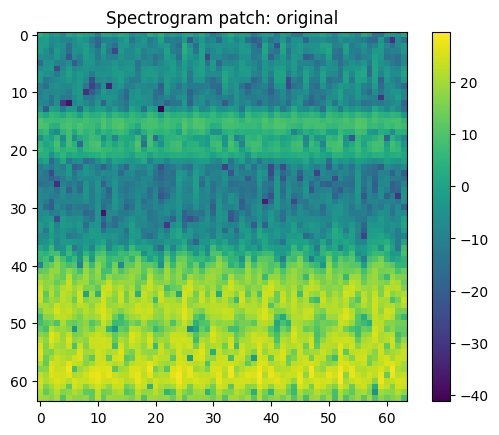

In [174]:
plt.imshow(a); plt.colorbar()
plt.title('Spectrogram patch: original')

Text(0.5, 1.0, 'Spectrogram patch: reconstructed')

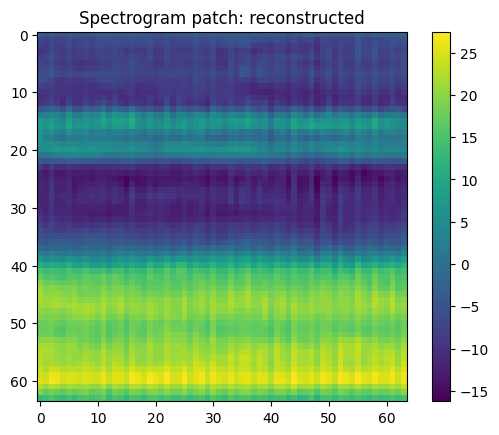

In [175]:
plt.imshow(b); plt.colorbar()
plt.title('Spectrogram patch: reconstructed')

Text(0.5, 1.0, 'Spectrogram patch: error')

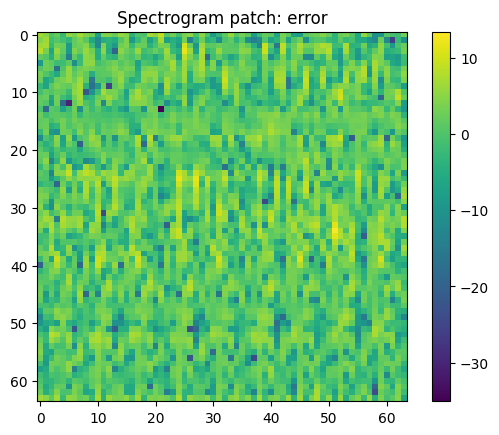

In [176]:
plt.imshow(a-b); plt.colorbar()
plt.title('Spectrogram patch: error')